<a href="https://colab.research.google.com/github/Santhosh-Kumar-Optisol/Changes_proposed_to_Daniel_Bourke_TF_course/blob/master/Corrections_in_Time_Series_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Rectification of a conceptual error in learning material

Hi Daniel Bourke, 

Hope you having a great day.

I just want to make you aware of a conceptual error in one of your videos and related study materials. 

* Course   : [TensorFlow Developer Certificate in 2023: Zero to Mastery](https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/)
* Platform : Udemy
* Section  : 12
* Videos   : 323, 324, 325
* Notebook : [10_time_series_forecasting_in_tensorflow.ipynb](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb)

I have only recreated the necessary parts of your notebook required to pin point and explain the conceptual error in model_4 (Conv1D) and model_5 (LSTM) sections. 

##Recreating the necessary parts from the original material

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [76]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

--2023-03-23 13:57:55--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2023-03-23 13:57:55 (8.47 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’ saved [178509/178509]



In [77]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [79]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


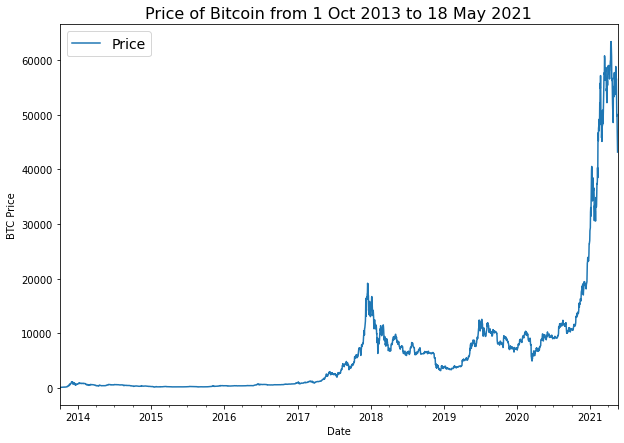

In [80]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

In [81]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [82]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [83]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [84]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [85]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

In [86]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

## Model 4 - Conv1D (as per your material)

In [87]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [88]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [89]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [90]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [91]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [92]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [93]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_15 (Lambda)          (None, 1, 7)              0         
                                                                 
 conv1d_10 (Conv1D)          (None, 1, 128)            4608      
                                                                 
 dense_8 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [94]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 567.9531


567.953125

In [95]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8902.465, 8800.512, 9031.084, 8806.953, 8760.355, 8765.559,
       8701.76 , 8545.073, 8486.491, 8539.211], dtype=float32)>

## Explanation and Suggestion to Rectifing the Error (Conv1D Model)

The error is in implementation of Expand_dims lambda layer.

In [96]:
# You have implemented the expand dimensions layer as follows
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

# And you have tested the above layer using the first element in train_windows
x = tf.constant(train_windows[0])
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


The problem with this implementation is that, It **won't** work like the same when a batch of train_windows elements is passed through the layer. Which is exactly the process happening while training a model.

In [98]:
print(f"Original shape: {train_windows.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(train_windows).shape}")
print(f"Expanded shape of first element : {expand_dims_layer(train_windows)[0].shape}")  
print(f"Original values of first element with expanded shape:\n {expand_dims_layer(train_windows)[0]}")

Original shape: (2224, 7)
Expanded shape: (2224, 1, 7)
Expanded shape of first element : (1, 7)
Original values of first element with expanded shape:
 [[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]]


I Guess you have also understood the error.

Expanding the inputs on axis=1, converts the shape from (batch_size, window_size) to (batch_size, 1, window_size).

This makes the model to interpret the input as "7 filters (convolutions) with feature map (input_dims or windows) of size 1". But in reality, the inputs have to be "1 filter with feature maps of size 7".

This small error in the initial layers creates confusion in the next Conv1D layers also.

In [99]:
Conv_layer = layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu")

print(f"Input Shape: {train_windows.shape}")

Expand_dims_output = expand_dims_layer(train_windows)
print(f"Expand_dims layer output shape: {Expand_dims_output.shape}")

Convoluted_output = Conv_layer(Expand_dims_output)
print(f"Convolution layer output shape: {Convoluted_output.shape}")

Input Shape: (2224, 7)
Expand_dims layer output shape: (2224, 1, 7)
Convolution layer output shape: (2224, 1, 128)


Check the above shapes. 

The convolution layer is convoluting on 7 filters input of size 1, to create 128 filters output of size 1. But this doesn't make sense.

Convoluting an input space of size 1 (with padding) using any kernel size, will always yields output space of size 1. If the same process is done without padding (padding='valid'), then the system would have thrown an exception.

The appropriate execution of Conv1D layer in this case, should coonvolute on 1 filter input of size 7, to create 128 filters output of size 7 (with padding) or 3 (without padding).

How to rectify this error?

The answer is simple. **Just change the expand_dims layer to expand the third axis (axis=2), instead of second axis (axis=1)**.

In [100]:
expand_dims_layer_new = layers.Lambda(lambda x: tf.expand_dims(x, axis=2))
Conv_layer_new = layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu")

# Lets check the shapes now.
print(f"Input Shape: {train_windows.shape}")

Expand_dims_output = expand_dims_layer_new(train_windows)
print(f"Expand_dims layer output shape: {Expand_dims_output.shape}")

Convoluted_output = Conv_layer_new(Expand_dims_output)
print(f"Convolution layer output shape: {Convoluted_output.shape}")

Input Shape: (2224, 7)
Expand_dims layer output shape: (2224, 7, 1)
Convolution layer output shape: (2224, 7, 128)


Now, we need a GlobalAveragePooling1D layer to convert the shape of (batch_size, 7, 128) to (batch_size, 128). 

This is to get a single value representation of 7 size input of all 128 filters.

Lets build the model again with the suggested changes.

In [101]:
tf.random.set_seed(42)

# Create model
model_4_new = tf.keras.Sequential([
  layers.Lambda(lambda x: tf.expand_dims(x, axis=2)), # Modification 1
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.GlobalAveragePooling1D(), # Modification 2
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4_new.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

In [102]:
# Fit model
model_4_new.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [103]:
model_4_new.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_18 (Lambda)          (None, 7, 1)              0         
                                                                 
 conv1d_13 (Conv1D)          (None, 7, 128)            768       
                                                                 
 global_average_pooling1d_3   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


In [104]:
model_4_new.predict(test_windows).shape

18/18 [==============================] - 0s 2ms/step


(556, 1)

In [105]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4_new = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4_new.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 861.9912


861.9912109375

In [106]:
# Make predictions
model_4_preds_new = make_preds(model_4_new, test_windows)
model_4_preds_new[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9258.289, 9118.913, 9048.403, 8964.356, 8927.561, 8880.487,
       8805.415, 8746.198, 8673.089, 8611.605], dtype=float32)>

The model trained in the appropriate architecture performed worst than the model built with shape error. then, 
* Why this way of model building should be adopted? 
* Why can't we just leave the model in the course materials as it is now?

The key point here, is the **"Appropriateness"**.

The section is titled and shown as `Conv1D Model`. But, Is the model really behaving as a Convolutional model?

Lets pay a close attention on whats happening inside the model in course material and videos.
* **expand_dims** layer converts the 7 window input to a 7 representation of 1 size inputs.
* **Conv1D** layer converts the 7 representations into 128 representations. We cannot say this process as a convolution, because it is only increasing the filter size by multiplying random numbers to the 1 size input. It is just behaving as a upscaling layer.
* **Dense** layer performs the regression and activation operations. 

By studying the above steps, we can only say that model is nothing but a Fully Connected Dense model with randomly modified inputs.

The same situation occurs in `LSTM Model` section. 

The solution is same. Modification is needed in the expand_dims layer. 

## Model 5 - RNN (LSTM) (as per your material)

In [107]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [108]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 593.3175


593.3175048828125

In [109]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 5ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8978.861 , 8839.768 , 8964.633 , 8843.9795, 8789.446 , 8721.888 ,
       8729.663 , 8595.321 , 8478.26  , 8531.749 ], dtype=float32)>

## Explanation and Suggestion to Rectifing the Error (LSTM Model)

Lets do the same modification of Expand_dims layer in this section also.

Here, the GlobalAveragePooling layer won't be necessary, since the default hyperparameter in LSTM (return_sequences=False) handles the aggregation of feature maps into single value representation.

In [112]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=2))(inputs) # Modification 3
x = layers.LSTM(128, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5_new = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")


model_5_new.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_5_new.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [113]:
model_5_new.summary()

Model: "model_5_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_20 (Lambda)          (None, 7, 1)              0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [114]:
# Load in best version of model 5 and evaluate on the test data
model_5_new = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5_new.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 675.7473


675.7472534179688

In [115]:
# Make predictions with our LSTM model
model_5_preds_new = make_preds(model_5_new, test_windows)
model_5_preds_new[:10]

18/18 [==============================] - 0s 7ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9089.042, 8861.103, 8880.5  , 8860.094, 8778.357, 8748.421,
       8720.3  , 8607.76 , 8503.15 , 8496.132], dtype=float32)>

I am happy to see myself learning, understanding, applying and debuging Deep Learning models. 

The ability to find this conceptual error and rectification, came through the deep understanding in working of Convolution layers, gained through Computer Vision and NLP sections of your course. 

Thank you for creating such a wonderful course and learning materials. 

Keep doing your art.

---

Thanks & regards

Santhosh Kumar, 

Machine Learning Engineer

[LinkedIn](https://www.linkedin.com/in/e-santhosh-kumar/), [GitHub](https://github.com/santhosh-kumar-e)